In [1]:
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, ReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD, Adam
from keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import CosineDecay

In [2]:
batch_size = 32
num_classes = 20
epochs = 100

In [3]:
#### LOAD AND TRANSFORM

## Download: ONLY ONCE!
os.system('wget https://www.dropbox.com/s/sakfqp6o8pbgasm/data.tgz')
os.system('tar xvzf data.tgz')
#####

0

(791, 250, 250, 3)
(791,)
(784, 250, 250, 3)
(784,)


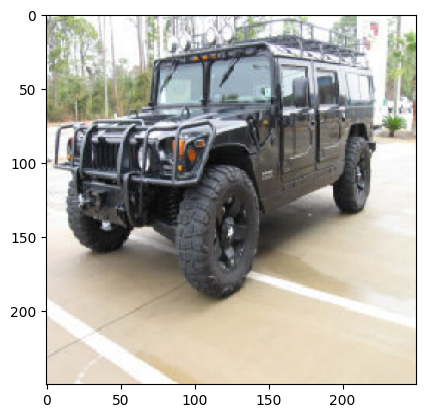

In [4]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

## View some images
plt.imshow(x_train[2,:,:,: ] )
plt.show()

In [5]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
# x_test = tf.keras.applications.resnet50.preprocess_input(x_test)
x_train = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test = tf.keras.applications.vgg16.preprocess_input(x_test)
# x_train /= 255
# x_test /= 255

## Labels
y_train=y_train-1

y_test=y_test-1

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# Stats
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(791, 250, 250, 3)
(791, 20)
(784, 250, 250, 3)
(784, 20)


In [7]:
datagen = ImageDataGenerator(
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

In [8]:
# base_model = tf.keras.applications.resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(250, 250, 3),
# )
# base_model.trainable = False
# # tf.keras.utils.plot_model(base_model, to_file='img.png', show_shapes=True)
# # for i, layer in enumerate(base_model.layers):
# #   if layer.name in ['conv1_conv', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']:
# #     print(i, layer.name, layer.output_shape)
# tf.keras.utils.plot_model(base_model, to_file='img.png', show_shapes=True)

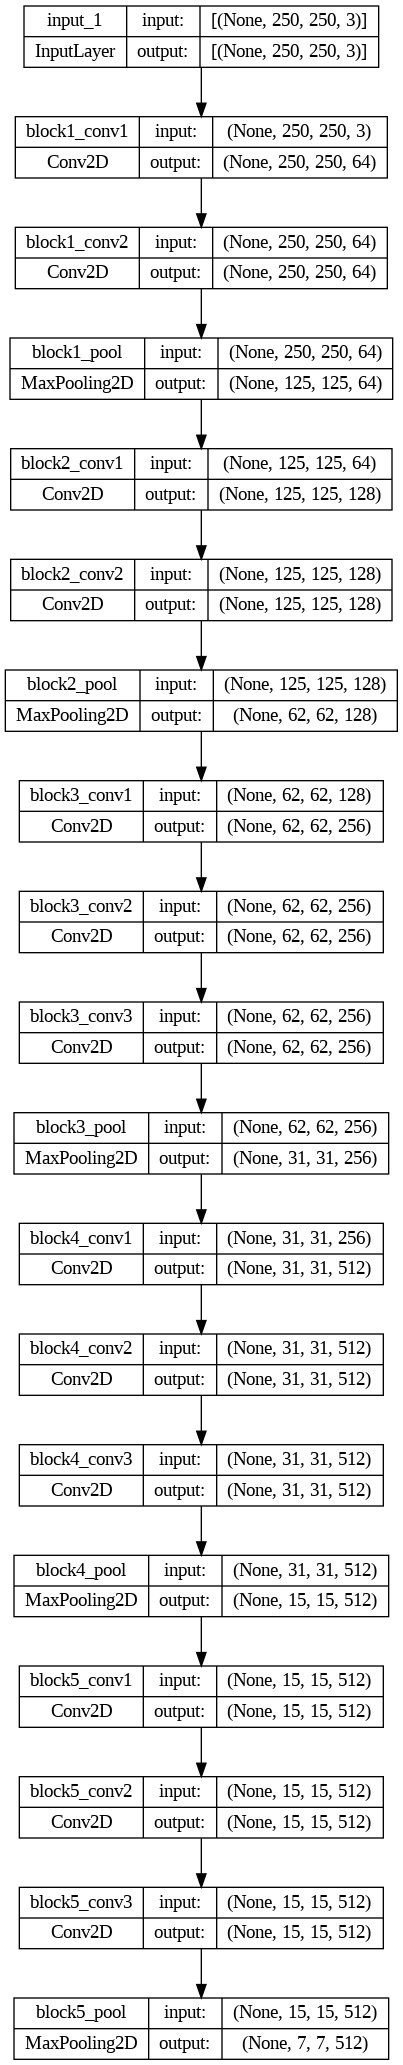

In [9]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(250, 250, 3),
)
base_model.trainable = False
tf.keras.utils.plot_model(base_model, to_file='img.png', show_shapes=True)

In [10]:
#############################
###      BILINEAR        ####
#############################
base_model.trainable = False
def outer_product(x):
  phi_I = tf.einsum('ijkm,ijkn->imn',x[0],x[1])		# Einstein Notation  [batch,31,31,depth] x [batch,31,31,depth] -> [batch,depth,depth]
  phi_I = tf.reshape(phi_I,[-1,512*512])	        # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
  phi_I = tf.divide(phi_I,31*31)								  # Divide by feature map size [sizexsize]

  y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))		# Take signed square root of phi_I
  z_l2 = tf.nn.l2_normalize(y_ssqrt)								              # Apply l2 normalization
  return z_l2

In [11]:
output=base_model.get_layer('block4_conv3')
# output=base_model.get_layer('conv3_block4_out')
d1=Dropout(0.5)(output.output)   ## Why??
d2=Dropout(0.5)(output.output)   ## Why??

x = Lambda(outer_product, name='outer_product')([d1,d2])
# x = BN()(x)
# x = GN(0.01)(x)
# x = Dropout(0.2)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)
model1 = Model(inputs=base_model.input, outputs=x)

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 250, 250, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 250, 250, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [12]:
## OPTIM AND COMPILE
# DEFINE A LEARNING RATE SCHEDULER
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1,
#                               patience=10, min_lr=0.005)
# decay_steps = int(epochs*len(x_train)/batch_size)
# print(decay_steps)
# lr = CosineDecay(0.1, decay_steps)

opt = Adam(learning_rate=0.1, decay=1e-6)
# opt = SGD(learning_rate=lr, momentum=0.9, decay=5e-4)
model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history=model1.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[early_stop],
                            verbose=1)

Epoch 1/100
24/24 [==============================] - 38s 1s/step - loss: 5.6045 - accuracy: 0.0973 - val_loss: 3.9956 - val_accuracy: 0.2117
Epoch 2/100
24/24 [==============================] - 16s 665ms/step - loss: 2.5850 - accuracy: 0.3287 - val_loss: 2.4212 - val_accuracy: 0.3546
Epoch 3/100
24/24 [==============================] - 21s 867ms/step - loss: 1.8018 - accuracy: 0.4766 - val_loss: 2.2624 - val_accuracy: 0.3954
Epoch 4/100
24/24 [==============================] - 19s 767ms/step - loss: 1.5016 - accuracy: 0.5689 - val_loss: 2.0250 - val_accuracy: 0.3776
Epoch 5/100
24/24 [==============================] - 17s 707ms/step - loss: 1.1371 - accuracy: 0.6839 - val_loss: 1.8728 - val_accuracy: 0.4554
Epoch 6/100
24/24 [==============================] - 16s 648ms/step - loss: 1.0711 - accuracy: 0.6979 - val_loss: 1.6453 - val_accuracy: 0.4758
Epoch 7/100
24/24 [==============================] - 17s 700ms/step - loss: 0.8544 - accuracy: 0.7598 - val_loss: 2.0621 - val_accuracy: 0.

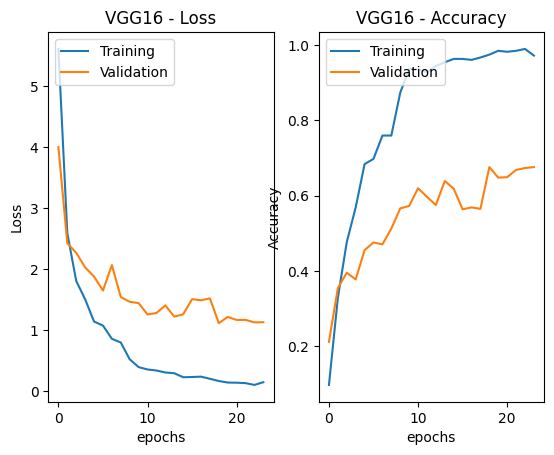

In [14]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 - Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [15]:
## OPTIM AND COMPILE
base_model.trainable = True
# decay_steps = int(epochs*len(x_train)/batch_size)
# print(decay_steps)
# lr = CosineDecay(0.001, decay_steps)

opt = Adam(learning_rate=0.0001, decay=1e-6)
# opt = SGD(learning_rate=lr, momentum=0.9, decay=5e-4)

model1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, cooldown=1,
#                               patience=10, min_lr=0.005)

In [16]:
epochs = 400
history1=model1.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[early_stop],
                            verbose=1)

Epoch 1/400
24/24 [==============================] - 43s 1s/step - loss: 0.7005 - accuracy: 0.8382 - val_loss: 1.1591 - val_accuracy: 0.6633
Epoch 2/400
24/24 [==============================] - 22s 886ms/step - loss: 0.1286 - accuracy: 0.9798 - val_loss: 1.1716 - val_accuracy: 0.6684
Epoch 3/400
24/24 [==============================] - 24s 946ms/step - loss: 0.0730 - accuracy: 0.9861 - val_loss: 1.1261 - val_accuracy: 0.6926
Epoch 4/400
24/24 [==============================] - 23s 915ms/step - loss: 0.0754 - accuracy: 0.9886 - val_loss: 1.1285 - val_accuracy: 0.6875
Epoch 5/400
24/24 [==============================] - 23s 906ms/step - loss: 0.0779 - accuracy: 0.9823 - val_loss: 1.0843 - val_accuracy: 0.6901
Epoch 6/400
24/24 [==============================] - 22s 901ms/step - loss: 0.0646 - accuracy: 0.9899 - val_loss: 1.2116 - val_accuracy: 0.6773
Epoch 7/400
24/24 [==============================] - 22s 892ms/step - loss: 0.0735 - accuracy: 0.9899 - val_loss: 1.0035 - val_accuracy: 0.

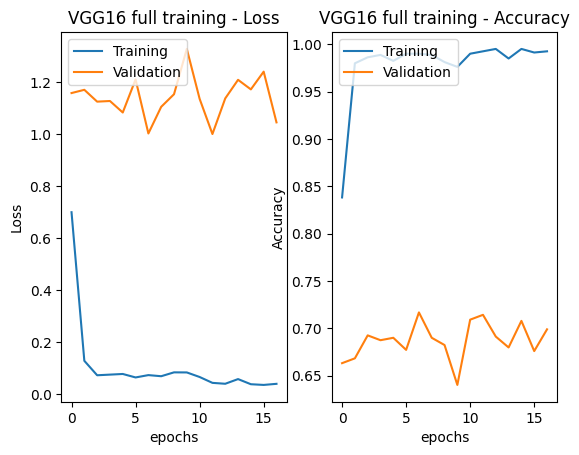

In [17]:
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('VGG16 full training - Loss')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('VGG16 full training - Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()